# HDR Plot

The *El Niño* dataset consists of 60 years worth of averaged monthly sea surface temperature (SST) in degrees Celcius of the Pacific Ocean at 0-10 deg South and 90-80 deg West between 1950 and 2007.
Years 1982-83 and 1997-98 are outliers; these are the years where *El Niño* (a climate pattern characterized by warming up of the sea surface and higher air pressures) occurred with unusual intensity.

Source: NOAA - ERSSTv5 - Nino 1+2 at http://www.cpc.ncep.noaa.gov/data/indices/

In [1]:
import os
import openturns as ot
import othdrplot as othdr
import openturns.viewer as otv

The minimum volume level set computation requires a sampling which can be costly with the default value of the parameters, due to a huge sampling size. Hence, we reduce it to 500.

In [2]:
n_samples = 500
ot.ResourceMap.SetAsBool("Distribution-MinimumVolumeLevelSetBySampling", True)
ot.ResourceMap.Set("Distribution-MinimumVolumeLevelSetSamplingSize", str(n_samples))

Load the dataset.

In [3]:
filename = os.path.join(othdr.__path__[0], "data/npfda-elnino.dat")
separatorstr = " "
data = ot.Sample.ImportFromTextFile(filename, separatorstr)

Create the mesh.

In [4]:
print("Number of dates : %d" % (data.getDimension()))
print("Number of fields : %d" % (data.getSize()))

Number of dates : 12
Number of fields : 54


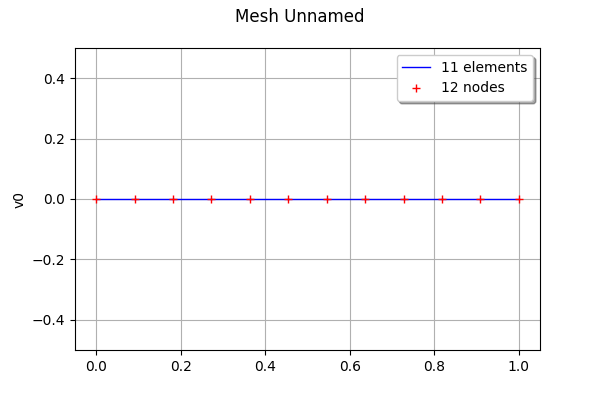

In [5]:
n_nodes = data.getDimension()
mesher = ot.IntervalMesher([n_nodes - 1])
interval = ot.Interval([0.0], [1.0])
mesh = mesher.build(interval)
mesh.draw()

Create the ProcessSample from the data.

In [6]:
n_fields = data.getSize()
d_fields = 1
processSample = ot.ProcessSample(mesh, n_fields, d_fields)
for i in range(n_fields):
    trajectory = ot.Sample([[x] for x in data[i, :]])
    processSample[i] = ot.Field(mesh, trajectory)

We reduce the dimension to 1 component: this is quite extreme.

In [7]:
# KL decomposition
reduction = othdr.KarhunenLoeveDimensionReductionAlgorithm(processSample, 1)
reduction.run()
reducedComponents = reduction.getReducedComponents()

# Distribution fit in reduced space
ks = ot.KernelSmoothing()
reducedDistribution = ks.build(reducedComponents)

We can visualize the sample and the distribution.

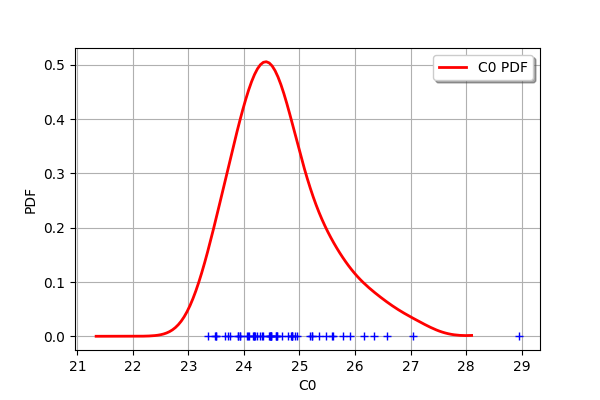

In [8]:
othdr.DrawUnivariateSampleDistribution(reducedComponents, reducedDistribution)

The `HighDensityRegionAlgorithm` class does not plot the high density regions in 1 dimension. 

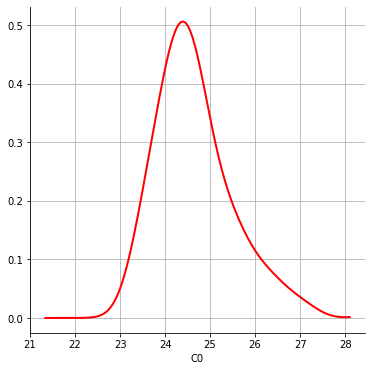

In [9]:
mydp = othdr.HighDensityRegionAlgorithm(
    reducedComponents, reducedDistribution, [0.8, 0.5]
)
mydp.run()
grid = mydp.draw(drawInliers=True)
view = otv.View(grid).getFigure().set_size_inches(6.0, 6.0)

In [10]:
hdr = othdr.ProcessHighDensityRegionAlgorithm(processSample, reducedComponents, reducedDistribution, [0.8, 0.5])
hdr.run()

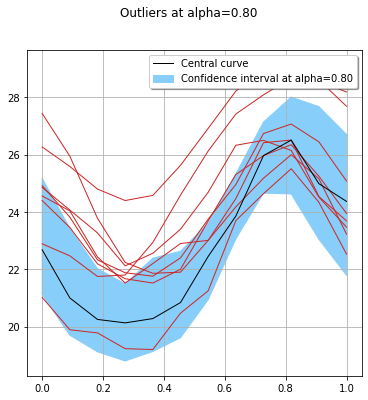

In [11]:
grid = hdr.draw()
view = otv.View(grid).getFigure().set_size_inches(6.0, 6.0)

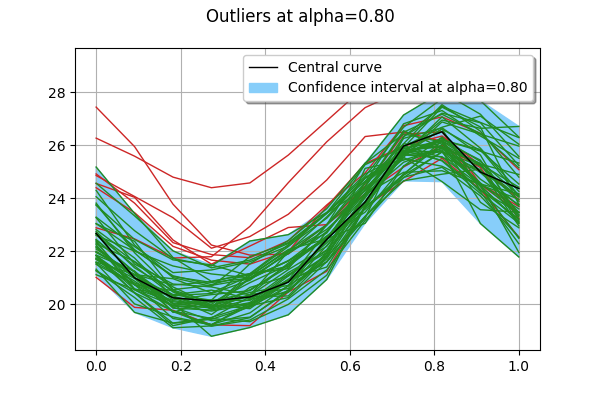

In [12]:
hdr.draw(drawInliers=True)

In [13]:
print("Outliers trajectories")
outlierIndices = hdr.computeIndices()
outlierIndices

Outliers trajectories


[1, 4, 7, 22, 26, 32, 33, 47]